# GETTING ALL THE REQUIRED FUNCTIONS

In [56]:
import pandas as pd
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F


In [57]:
# CALLING SPARK

spark = SparkSession.builder.appName("ProjectEVs").getOrCreate()

In [58]:
## IGNORING WARNINGS

import warnings
warnings.filterwarnings("ignore")

# LOADING FILES TO DATAFRAMES

In [59]:
df_date = spark.read.csv("dim_date.csv", inferSchema=True, header=True)
df_makers = spark.read.csv("electric_vehicle_sales_by_makers.csv", inferSchema=True, header=True)
df_state = spark.read.csv("electric_vehicle_sales_by_state.csv", inferSchema=True, header=True)

In [60]:
## CHECKING SCHEMAS

df_makers.show()

+---------+----------------+----------------+----------------------+
|     date|vehicle_category|           maker|electric_vehicles_sold|
+---------+----------------+----------------+----------------------+
|01-Apr-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Apr-22|      2-Wheelers|        OKAYA EV|                     0|
|01-May-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Jun-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Jul-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Aug-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Sep-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Oct-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Nov-21|      2-Wheelers|    OLA ELECTRIC|                     0|
|01-Apr-21|      4-Wheelers|       BYD India|                     0|
|01-Apr-21|      4-Wheelers| PCA Automobiles|                     0|
|01-Apr-21|      4-Wheelers|      

In [61]:
df_makers.dtypes

[('date', 'string'),
 ('vehicle_category', 'string'),
 ('maker', 'string'),
 ('electric_vehicles_sold', 'int')]

In [62]:
df_state.dtypes

[('date', 'string'),
 ('state', 'string'),
 ('vehicle_category', 'string'),
 ('electric_vehicles_sold', 'int'),
 ('total_vehicles_sold', 'int')]

# TRANSFORMATIONS

In [63]:
## CONVERTING THE DATE COLUMN TO dd-MM-yyy FORMAT

dataframes = {
    "df_date":df_date,
    "df_makers":df_makers,
    "df_state":df_state
}

for i, df in dataframes.items():
    dataframes[i] = df.withColumn("date",date_format(to_date(df["date"], "dd-MMM-yy"), "dd-MM-yyyy"))

df_date = dataframes["df_date"]
df_makers = dataframes["df_makers"]
df_state = dataframes["df_state"]


In [64]:
df_makers.dtypes

[('date', 'string'),
 ('vehicle_category', 'string'),
 ('maker', 'string'),
 ('electric_vehicles_sold', 'int')]

In [65]:
## CONVERTING THE DATE Datatype to DATE Datatype

dataframes = {
    "df_date":df_date,
    "df_makers":df_makers,
    "df_state":df_state
}

for i, df in dataframes.items():
    dataframes[i] = df.withColumn("date",to_date(df["date"], "dd-MM-yyyy"))

df_date = dataframes["df_date"]
df_makers = dataframes["df_makers"]
df_state = dataframes["df_state"]


In [66]:
df_date.dtypes

[('date', 'date'), ('fiscal_year', 'int'), ('quarter', 'string')]

In [67]:
df_date.dropDuplicates()
df_state.dropDuplicates()
df_makers.dropDuplicates()

DataFrame[date: date, vehicle_category: string, maker: string, electric_vehicles_sold: int]

## PRELIMINARY ADHOC RESULTS

### 1.List the top 3 and bottom 3 makers for the fiscal years 2023 and 2024 in terms of the number of 2-wheelers sold. ###


In [68]:
## List the top 3 and bottom 3 makers for the fiscal years 2023 and 2024 in terms of the number of 2-wheelers sold.


# Joining makers and date table, state and date tables on date column

df_makers_date = df_makers.join(df_date, on="date")
df_state_date = df_state.join(df_date, on="date")

#filtering 2-wheelers and grouping them by Maker and date

df_2wheelers_makers = df_makers_date.filter(col("vehicle_category")=="2-Wheelers")\
                                     .groupby("maker","fiscal_year")\
                                    .agg(sum("electric_vehicles_sold").alias("TotalElecricVehiclesSold"))

WindowSpec = Window.partitionBy("fiscal_year").orderBy(col("TotalElecricVehiclesSold").desc())
WindowSpec2 = Window.partitionBy("fiscal_year").orderBy(col("TotalElecricVehiclesSold").asc())

df_ranked = df_2wheelers_makers.withColumn("rank", rank().over(WindowSpec))
df_ranked2 = df_2wheelers_makers.withColumn("rank", rank().over(WindowSpec2))

top_3 = df_ranked.filter(col("rank")<=3)
bottom_3 = df_ranked2.filter(col("rank")<=3)

print("The Top 3 Electric Vehicles Sold for 2 wheelers are:")
top_3.orderBy("fiscal_year", "rank").show(truncate = False)

print("The Bottom 3 Electric Vehicles Sold for 2 wheelers are:")
bottom_3.orderBy("fiscal_year", "rank").show(truncate= False)


The Top 3 Electric Vehicles Sold for 2 wheelers are:
+-------------+-----------+------------------------+----+
|maker        |fiscal_year|TotalElecricVehiclesSold|rank|
+-------------+-----------+------------------------+----+
|HERO ELECTRIC|2022       |69452                   |1   |
|OKINAWA      |2022       |47665                   |2   |
|AMPERE       |2022       |25510                   |3   |
|OLA ELECTRIC |2023       |152583                  |1   |
|OKINAWA      |2023       |96945                   |2   |
|HERO ELECTRIC|2023       |88993                   |3   |
|OLA ELECTRIC |2024       |322489                  |1   |
|TVS          |2024       |180743                  |2   |
|ATHER        |2024       |107552                  |3   |
+-------------+-----------+------------------------+----+

The Bottom 3 Electric Vehicles Sold for 2 wheelers are:
+---------------+-----------+------------------------+----+
|maker          |fiscal_year|TotalElecricVehiclesSold|rank|
+---------------

### 2. Identify the top 5 states with the highest penetration rate in 2-wheeler and 4-wheeler EV sales in FY 2024. ###

In [69]:
df_state_date_2024 = df_state_date.filter(col("fiscal_year") == 2024)

df_state_date_2024 = df_state_date_2024.withColumn("penetrationrate",(col("electric_vehicles_sold")/col("total_vehicles_sold"))*100)

df_grouped_2024 = df_state_date_2024.groupBy("state", "vehicle_category").agg(round(expr("avg(penetrationrate)"),2).alias("Avg_Penetration_rate"))

##Calculating top 5 states for 2 wheeelers
df_2w_rate_2024 = df_grouped_2024.filter(col("vehicle_category") == "2-Wheelers").orderBy(col("Avg_Penetration_rate").desc()).limit(5)

##Calculating top 5 states for 4 wheeelers
df_4w_rate_2024 = df_grouped_2024.filter(col("vehicle_category") == "4-Wheelers").orderBy(col("Avg_Penetration_rate").desc()).limit(5)

print("Top 5 States wuth highest Penetration Rate for 2 Wheelers:")
df_2w_rate_2024.show(truncate=False)

print("Top 5 States wuth highest Penetration Rate for 4 Wheelers:")
df_4w_rate_2024.show(truncate=False)

Top 5 States wuth highest Penetration Rate for 2 Wheelers:
+-----------+----------------+--------------------+
|state      |vehicle_category|Avg_Penetration_rate|
+-----------+----------------+--------------------+
|Goa        |2-Wheelers      |18.18               |
|Kerala     |2-Wheelers      |13.61               |
|Karnataka  |2-Wheelers      |11.51               |
|Maharashtra|2-Wheelers      |10.16               |
|Delhi      |2-Wheelers      |9.7                 |
+-----------+----------------+--------------------+

Top 5 States wuth highest Penetration Rate for 4 Wheelers:
+----------+----------------+--------------------+
|state     |vehicle_category|Avg_Penetration_rate|
+----------+----------------+--------------------+
|Kerala    |4-Wheelers      |42.31               |
|Chandigarh|4-Wheelers      |4.91                |
|Goa       |4-Wheelers      |4.37                |
|Karnataka |4-Wheelers      |4.28                |
|Delhi     |4-Wheelers      |4.26                |
+----

### 3. List the states with negative penetration (decline) in EV sales from 2022 to 2024? ###

In [70]:
df_penetration_22_24 = df_state_date.filter(col("fiscal_year").isin(2022, 2024))\
                                    .groupBy("state","fiscal_year", "vehicle_category")\
                                    .agg(sum("electric_vehicles_sold").alias("EVSold"),sum("total_vehicles_sold").alias("TotalSold"))\
                                    .withColumn("penetrationrate",round(expr("EVSold/TotalSold*100"),2))

df_penetration_slice = df_penetration_22_24.groupBy("state","vehicle_category")\
                                           .pivot("fiscal_year").agg(sum("penetrationrate").alias("penetrationrate"))

df_penetration_compare = df_penetration_slice.withColumn("DiffPenetrationRate", round(col("2024")-col("2022"),2))\
                                             .filter(col("DiffPenetrationRate")<0)

df_penetration_compare.show(truncate=False)

+------------------------+----------------+----+----+-------------------+
|state                   |vehicle_category|2022|2024|DiffPenetrationRate|
+------------------------+----------------+----+----+-------------------+
|Andaman & Nicobar Island|4-Wheelers      |1.88|0.84|-1.04              |
|Ladakh                  |2-Wheelers      |4.48|4.06|-0.42              |
+------------------------+----------------+----+----+-------------------+



### 4. What are the quarterly trends based on sales volume for the top 5 EV makers (4-wheelers) from 2022 to 2024? ###

<Figure size 1400x800 with 0 Axes>

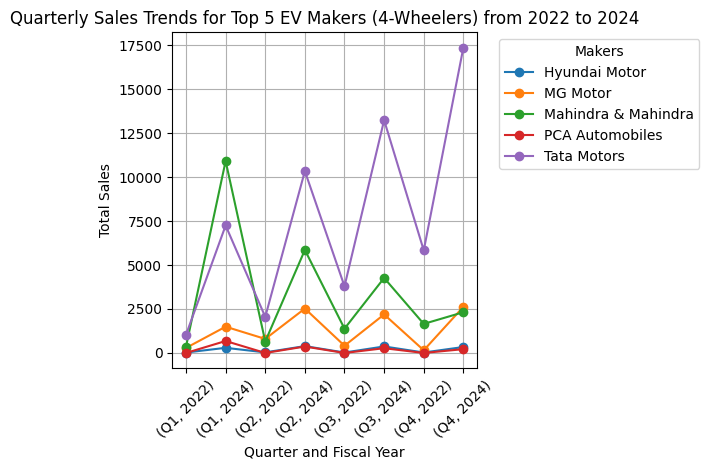

In [71]:
## Filter for fiscal years between 2022 to 2024 and Vehicle Category '4-Wheelers'
df_filter_fiscalyear_vehcat = df_makers_date.filter((col("fiscal_year").isin(2022, 2024) &
                                     (col("vehicle_category") == "4-Wheelers")))

df_filter_fiscalyear_vehcat_grouped = df_filter_fiscalyear_vehcat.groupBy("maker","fiscal_year", "vehicle_category", "quarter")\
                                                                 .agg(sum("electric_vehicles_sold").alias("TotalEvsSold"))

df_4W_top5 = df_filter_fiscalyear_vehcat_grouped.groupBy("maker")\
                                                .agg(sum("TotalEvsSold").alias("TotalEvsSoldAllYears"))\
                                                .orderBy(col("TotalEvsSoldAllYears").desc())\
                                                .limit(5)

df_quarter_trends = df_filter_fiscalyear_vehcat_grouped.join(df_4W_top5, on="maker")\
                                                       .select("maker", "quarter","fiscal_year","TotalEvsSold")

df_quarter_trends_pandas = df_quarter_trends.toPandas()

# Pivot data for easier plotting
df_pivot = df_quarter_trends_pandas.pivot_table(index=["quarter", "fiscal_year"], 
                                             columns="maker", 
                                             values="TotalEvsSold", 
                                             aggfunc="sum")

# Plotting the quarterly trends
plt.figure(figsize=(14, 8))
df_pivot.plot(kind="line", marker='o')
plt.title('Quarterly Sales Trends for Top 5 EV Makers (4-Wheelers) from 2022 to 2024')
plt.xlabel('Quarter and Fiscal Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title="Makers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5. How do the EV sales and penetration rates in Delhi compare to Karnataka for 2024? ###

       state vehicle_category  TotalEvsSold  TotalSold  penetrationrate
0      Delhi       4-Wheelers          8630     201130         4.290757
1  Karnataka       2-Wheelers        148111    1279767        11.573279
2  Karnataka       4-Wheelers         12878     302221         4.261120
3      Delhi       2-Wheelers         38094     405218         9.400866


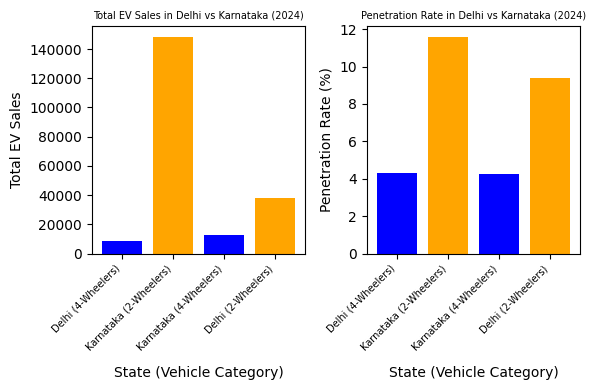

In [72]:
## Filtering columns for 2024 fiscalyear and states for Delhi and Karnataka
df_ev_penetration_filter = df_state_date.filter((col("state").isin("Delhi", "Karnataka")) & 
                                         (col("fiscal_year") == 2024))

## Grouping the filtered columns with state and vehiclecategory with aggregating TotalVehicles and ElectricVehicles
## Adding Penetration Rate Column with the formula for calculation
df_ev_penetration_filter_grouped = df_ev_penetration_filter.groupBy("state", "vehicle_category")\
                                                           .agg(sum("electric_vehicles_sold").alias("TotalEvsSold"),
                                                            sum("total_vehicles_sold").alias("TotalSold"))\
                                                           .withColumn("penetrationrate",expr("TotalEvsSold/TotalSold * 100"))

## Moving the dataframe to toPandas() for visualization and data handling
df_ev_penetration_pandas = df_ev_penetration_filter_grouped.toPandas()

print(df_ev_penetration_pandas)

## Ploting the Bar Charts for both EV sales and Penetration Rate Comparisions
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.bar(df_ev_penetration_pandas['state'] + ' (' + df_ev_penetration_pandas['vehicle_category'] + ')', 
        df_ev_penetration_pandas['TotalEvsSold'], color=['blue', 'orange'])
plt.title('Total EV Sales in Delhi vs Karnataka (2024)', fontsize = 7)
plt.xlabel('State (Vehicle Category)', labelpad=10)
plt.ylabel('Total EV Sales')

plt.xticks(rotation = 45, ha='right', fontsize = 7)

# Bar plot for penetration rate
plt.subplot(1, 2, 2)
plt.bar(df_ev_penetration_pandas['state'] + ' (' + df_ev_penetration_pandas['vehicle_category'] + ')', 
        df_ev_penetration_pandas['penetrationrate'], color=['blue', 'orange'])
plt.title('Penetration Rate in Delhi vs Karnataka (2024)', fontsize = 7)
plt.xlabel('State (Vehicle Category)', labelpad=10)
plt.ylabel('Penetration Rate (%)')

plt.xticks(rotation=45, ha='right', fontsize = 7)

plt.tight_layout()
plt.show()

### 6. Estimate the revenue growth rate of 4-wheeler and 2-wheelers EVs in India for 2022 vs 2024 and 2023 vs 2024, assuming an average unit price. H ###

In [89]:
# The Average Prices are defined using several websites and articles
avg_price_4w = 13804 #(In USD)
avg_price_2w = 1458 #(In USD)

# Revenue GrowthRate for 2022 Vs 2024
    # Revenue GrowthRate = (Revenue 2024 - Revenue 2022)/(Revenue 2022)*100
# Revenue GrowthRate for 2023 Vs 2024
    # Revenue GrowthRate = (Revenue 2024 - Revenue 2023)/(Revenue 2023)*100

# Calculate Total Revenue
df_state_with_revenue = df_state_date.withColumn(
    "TotalRevenue",
    F.when(F.col("vehicle_category") == "4-Wheelers", F.col("electric_vehicles_sold") * avg_price_4w)
    .when(F.col("vehicle_category") == "2-Wheelers", F.col("electric_vehicles_sold") * avg_price_2w)
)

# Aggregate Total Revenue by Fiscal Year and Vehicle Category
df_revenue_each_year = df_state_with_revenue.groupBy("fiscal_year", "vehicle_category")\
                                            .agg(F.sum("TotalRevenue").alias("Total_Revenue"))\

# Convert to Pandas DataFrame
df_revenue = df_revenue_each_year.toPandas()

# Calculate Revenue Growth Rates
df_revenue_pivot = df_revenue.pivot(index='vehicle_category', columns='fiscal_year', values='Total_Revenue')

# Initialize Growth Rate DataFrame
df_growthrate = pd.DataFrame()
df_growthrate['growthrate_22v24% In USD'] = ((df_revenue_pivot[2024] - df_revenue_pivot[2022]) / df_revenue_pivot[2022]) * 100
df_growthrate['growthrate_23v24% In USD'] = ((df_revenue_pivot[2024] - df_revenue_pivot[2023]) / df_revenue_pivot[2023]) * 100

# Reset index to make 'vehicle_category' a column again
df_growthrate.reset_index(inplace=True)

df_growthrate = df_growthrate.round(2)
print("Growth Rates:")
print(df_growthrate)

Growth Rates:
  vehicle_category  growthrate_22v24% In USD  growthrate_23v24% In USD
0       2-Wheelers                    269.28                     28.13
1       4-Wheelers                    367.79                     83.08


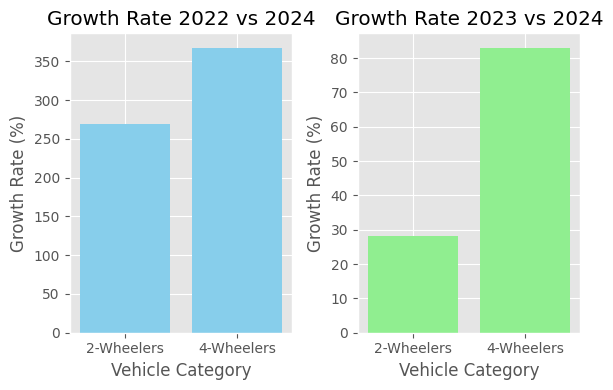

In [90]:
# Set the style of the visualization
plt.style.use('ggplot')

# Create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

# Bar plot for Growth Rate 2022 vs 2024
ax[0].bar(df_growthrate['vehicle_category'], df_growthrate['growthrate_22v24% In USD'], color='skyblue')
ax[0].set_title('Growth Rate 2022 vs 2024')
ax[0].set_ylabel('Growth Rate (%)')
ax[0].set_xlabel('Vehicle Category')

# Bar plot for Growth Rate 2023 vs 2024
ax[1].bar(df_growthrate['vehicle_category'], df_growthrate['growthrate_23v24% In USD'], color='lightgreen')
ax[1].set_title('Growth Rate 2023 vs 2024')
ax[1].set_ylabel('Growth Rate (%)')
ax[1].set_xlabel('Vehicle Category')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### 6.List down the compounded annual growth rate (CAGR) in 4-wheeler units for the top 5 makers from 2022 to 2024. ###

In [115]:
from pyspark.sql import functions as F

# Filter data for 4-wheelers
df_4wheelers = df_makers_date.filter(col("vehicle_category") == "4-Wheelers")

# Group by maker and fiscal year and aggregate sales
df_4wheelers_sales = df_4wheelers.groupBy("maker", "fiscal_year")\
    .agg(F.sum("electric_vehicles_sold").alias("total_sold"))

# Pivot to get sales data in columns
df_pivot = df_4wheelers_sales.groupBy("maker")\
    .pivot("fiscal_year")\
    .agg(F.sum("total_sold"))

# No.of Years
years = 2

# Calculate CAGR
df_cagr = df_pivot.withColumn(
    "CAGR",
    ((col("2024") / col("2022")) ** (1 / years) - 1) * 100
)

# Get top 5 makers by total sales in 2024
df_top_5_makers = df_cagr.orderBy(col("CAGR").desc())

# Show the result
df_top_5_makers.show()


+-------------------+-----+-----+-----+------------------+
|              maker| 2022| 2023| 2024|              CAGR|
+-------------------+-----+-----+-----+------------------+
|          BMW India|    7|  285| 1078|1140.9673645990856|
|   Volvo Auto India|    4|  105|  459| 971.2142642814275|
|          BYD India|   33|  920| 1466| 566.5151342936065|
|      Hyundai Motor|  110|  576| 1390| 255.4766326548573|
|  Mercedes -Benz AG|   26|   71|  291|234.54906504588666|
|Mahindra & Mahindra| 4042|13805|23346|140.33005508784265|
|           MG Motor| 1647| 3277| 8829|131.53089940016466|
|        Tata Motors|12708|28046|48181| 94.71495190679495|
|    PCA Automobiles|    0|  151| 1533|              NULL|
|         KIA Motors|    0|  229|  328|              NULL|
+-------------------+-----+-----+-----+------------------+



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


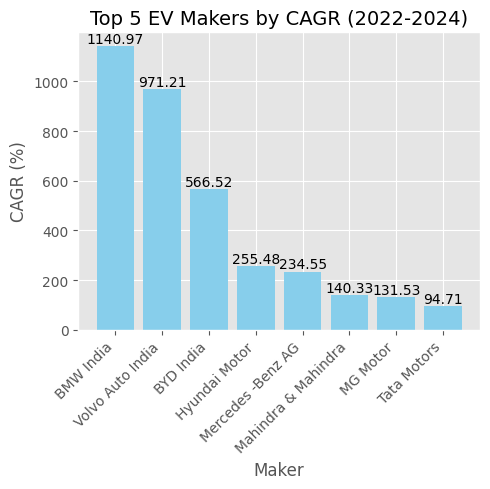

In [116]:
df_top_5_makers_pd = df_top_5_makers.toPandas()

# Plotting
plt.figure(figsize=(5, 5))

# Bar plot for CAGR
plt.bar(df_top_5_makers_pd['maker'], df_top_5_makers_pd['CAGR'], color='skyblue')

# Adding labels and title
plt.xlabel('Maker', fontsize=12)
plt.ylabel('CAGR (%)', fontsize=12)
plt.title('Top 5 EV Makers by CAGR (2022-2024)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adding value labels on top of the bars
for index, value in enumerate(df_top_5_makers_pd['CAGR']):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()